In [2]:
import pandas
import re
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import InputLayer, Masking, LSTM, TimeDistributed, Dense
from math import ceil
from keras.callbacks import Callback, ModelCheckpoint

Using TensorFlow backend.


In [3]:
csvs = list(filter(lambda file: re.match(r'^(?!61706006)\d{8} Test Data\.txt$', file) is not None, os.listdir('./DynamometerData')))

In [4]:
dfs = [pandas.read_csv('./DynamometerData/' + csv, sep='\t', header=0) for csv in csvs]

In [6]:
max_length = (ceil(max([len(df) for df in dfs]) / 100)) * 100
max_length

61600

In [7]:
# Padding with invalid value -1.
X = np.full([len(dfs), max_length, 10], -1.)
Y = np.full([len(dfs), max_length, 8], -1.)

for i, df in enumerate(dfs):
       
    # Current
    X[i,:len(df)-1,0] += df['Brake_pressure_applied_PCM[]'].values[1:] + 1
    X[i,:len(df)-1,1] += df['Pedal_accel_pos_CAN[per]'].values[1:] + 1
    
    # Previous
    X[i,:len(df)-1,2] += df['Dyno_Spd[mph]'].values[:-1] + 1
    X[i,:len(df)-1,3] += df['Eng_throttle_electronic_control_actual_PCM[deg]'].values[:-1] + 1
    X[i,:len(df)-1,4] += df['Eng_throttle_position_PCM[per]'].values[:-1] + 1
    X[i,:len(df)-1,5] += df['Trans_gear_engaged_CAN[]'].values[:-1] + 1
    X[i,:len(df)-1,6] += df['Eng_load_PCM[per]'].values[:-1] + 1
    X[i,:len(df)-1,7] += df['Eng_speed_PCM[rpm]'].values[:-1] + 1
    X[i,:len(df)-1,8] += df['Trans_gear_ratio_measured_TCM[]'].values[:-1] + 1
    X[i,:len(df)-1,9] += df['Trans_output_shaft_speed_raw_TCM[rpm]'].values[:-1] + 1
        
    # Outputs
    Y[i,:len(df)-1,0] += df['Dyno_Spd[mph]'].values[1:] + 1
    Y[i,:len(df)-1,1] += df['Eng_throttle_electronic_control_actual_PCM[deg]'].values[1:] + 1
    Y[i,:len(df)-1,2] += df['Eng_throttle_position_PCM[per]'].values[1:] + 1      
    Y[i,:len(df)-1,3] += df['Trans_gear_engaged_CAN[]'].values[1:] + 1
    Y[i,:len(df)-1,4] += df['Eng_load_PCM[per]'].values[1:] + 1
    Y[i,:len(df)-1,5] += df['Eng_speed_PCM[rpm]'].values[1:] + 1
    Y[i,:len(df)-1,6] += df['Trans_gear_ratio_measured_TCM[]'].values[1:] + 1
    Y[i,:len(df)-1,7] += df['Trans_output_shaft_speed_raw_TCM[rpm]'].values[1:] + 1
    

In [8]:
del dfs

In [9]:
NEW_MIN = 0.25
NEW_MAX = 0.75
OLD_PAD_VAL = -1.
NEW_PAD_VAL = 0.

X_mins, X_maxs = [], []

for k in range(X.shape[2]):
    
    X_mins.append(X[:,:,k][X[:,:,k] != OLD_PAD_VAL].min())
    X_maxs.append(X[:,:,k][X[:,:,k] != OLD_PAD_VAL].max())
    
X_std = np.full(X.shape, NEW_PAD_VAL)

for i in range(X.shape[0]):    
    for k in range(X.shape[2]):
        
        indices = np.where(X[i,:,k] != OLD_PAD_VAL)        
        X_std[i,indices,k] += ((X[i,indices,k] - X_mins[k]) / (X_maxs[k] - X_mins[k])) * (NEW_MAX - NEW_MIN) + NEW_MIN - NEW_PAD_VAL

Y_mins, Y_maxs = [], []

for k in range(Y.shape[2]):
    
    Y_mins.append(Y[:,:,k][Y[:,:,k] != OLD_PAD_VAL].min())
    Y_maxs.append(Y[:,:,k][Y[:,:,k] != OLD_PAD_VAL].max())

Y_std = np.full(Y.shape, NEW_PAD_VAL)

for i in range(Y.shape[0]):
    for k in range(Y.shape[2]):
        
        indices = np.where(Y[i,:,k] != OLD_PAD_VAL)
        Y_std[i,indices,k] += ((Y[i,indices,k] - Y_mins[k]) / (Y_maxs[k] - Y_mins[k])) * (NEW_MAX - NEW_MIN) + NEW_MIN - NEW_PAD_VAL

In [11]:
SPLIT = X_std.shape[0] - X_std.shape[0] // 10

indices = np.arange(0, X_std.shape[0])
np.random.shuffle(indices)

X_shuffled = X_std[indices,:,:]
Y_shuffled = Y_std[indices,:,:]

X_train, X_test = X_shuffled[:SPLIT,:,:], X_shuffled[SPLIT:,:,:]
Y_train, Y_test = Y_shuffled[:SPLIT,:,:], Y_shuffled[SPLIT:,:,:]

In [15]:
test_model = Sequential()

test_model.add(InputLayer(batch_input_shape=(1, 1, X_std.shape[2])))
test_model.add(LSTM(200, stateful=True))
test_model.add(Dense(Y_std.shape[2], activation='linear'))

test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 200)                  168800    
_________________________________________________________________
dense_1 (Dense)              (1, 8)                    1608      
Total params: 170,408
Trainable params: 170,408
Non-trainable params: 0
_________________________________________________________________


In [33]:
test_model.load_weights('Models/MaximalStateLSTM/E200L9.6744E-06.hdf5')

In [34]:
test_model.reset_states()

In [37]:
i = 2

Y_pred = np.zeros([1, Y_test.shape[1], Y_test.shape[2]])

inputs = X_train[i:i+1,0:1,:].copy()

j = 0
while X_train[i,j,0] != 0.:
    
    Y_pred[0,j:j+1,:] += test_model.predict(inputs, batch_size=1)

    inputs[0,0,:2] = X_train[i:i+1,j+1:j+2,:2]
    inputs[0,0,2:] = Y_pred[0,j:j+1,:]
    
    j += 1
    
test_model.reset_states()

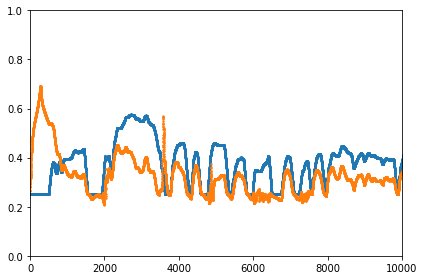

In [38]:
fig, ax = plt.subplots()

ax.scatter(range(max_length), Y_train[i,:,0], s=2)
ax.scatter(range(max_length), Y_pred[0,:,0], s=2)

# Zoom in
plt.xlim(0, 10000)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()